In [9]:
# import os
## Do not preallocate GPU memory
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = '\"platform\"'

from nodax import *
# jax.config.update("jax_debug_nans", True)




#%%

## Hyperparams

# ## Take seed as a paramter with argparse !! ONLY during testing.
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--seed", type=int, default=1176)
# seed = parser.parse_args().seed

seed = 1181

context_size = 1024
nb_epochs = 5000
nb_epochs_adapt = 5000

print_error_every = 1000

train = True
save_trainer = False

finetune = False
# run_folder = "./runs/30012024-103849/"      ## Only needed if not training

adapt = True
adapt_huge = False

In [10]:
if train == True:

    # check that 'tmp' folder exists. If not, create it
    if not os.path.exists('./runs'):
        os.mkdir('./runs')

    # Make a new folder inside 'tmp' whose name is the current time
    run_folder = './runs/'+time.strftime("%d%m%Y-%H%M%S")+'/'
    # run_folder = "./runs/23012024-163033/"
    os.mkdir(run_folder)
    print("Data folder created successfuly:", run_folder)

    # Save the run and dataset scripts in that folder
    script_name = os.path.basename(__file__)
    os.system(f"cp {script_name} {run_folder}")
    os.system(f"cp dataset.py {run_folder}")

    # Save the nodax module files as well
    os.system(f"cp -r ../../nodax {run_folder}")
    print("Completed copied scripts ")


else:
    run_folder = "./runs/30012024-115643/"  ## Needed for loading the model and finetuning TODO: opti
    print("No training. Loading data and results from:", run_folder)

## Create a folder for the adaptation results
adapt_folder = run_folder+"adapt/"
if not os.path.exists(adapt_folder):
    os.mkdir(adapt_folder)

Data folder created successfuly: ./runs/30012024-165151/
Completed copied scripts 


In [11]:
if train == True:
    # Run the dataset script to generate the data
    os.system(f'python dataset.py --split=train --savepath="{run_folder}" --seed="{seed}"')
    os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}"')
if adapt == True:
    os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}"');
if adapt_huge == True:
    os.system(f'python dataset.py --split=adapt_huge --savepath="{adapt_folder}" --seed="{seed*4}"');

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: train
 Savepath: ./runs/30012024-165151/
 Seed: 1181

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: test
 Savepath: ./runs/30012024-165151/
 Seed: 2362

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt
 Savepath: ./runs/30012024-165151/adapt/
 Seed: 3543



In [12]:
np.load(run_folder+"train_data.npz")['X'].shape

(25, 4, 100, 2)

In [13]:
## Define dataloader for training
train_dataloader = DataLoader(run_folder+"train_data.npz", batch_size=4, int_cutoff=0.25, shuffle=True, key=seed)

nb_envs = train_dataloader.nb_envs
nb_trajs_per_env = train_dataloader.nb_trajs_per_env
nb_steps_per_traj = train_dataloader.nb_steps_per_traj
data_size = train_dataloader.data_size

Dataset shape: (25, 4, 100, 2)


In [14]:
## Define model and loss function for the learner

activation = jax.nn.softplus
# activation = jax.nn.swish

class Physics(eqx.Module):
    layers: list

    def __init__(self, width_size=8, key=None):
        keys = generate_new_keys(key, num=4)
        self.layers = [eqx.nn.Linear(context_size, width_size*2, key=keys[0]), activation,
                        eqx.nn.Linear(width_size*2, width_size*2, key=keys[1]), activation,
                        eqx.nn.Linear(width_size*2, width_size, key=keys[2]), activation,
                        eqx.nn.Linear(width_size, 4, key=keys[3])]

    def __call__(self, t, x, ctx):
        params = ctx
        for layer in self.layers:
            params = layer(params)
        params = jnp.abs(params)

        dx0 = x[0]*params[0] - x[0]*x[1]*params[1]
        dx1 = x[0]*x[1]*params[3] - x[1]*params[2]
        return jnp.array([dx0, dx1])

class Augmentation(eqx.Module):
    layers_data: list
    layers_context: list
    layers_shared: list

    def __init__(self, data_size, width_size, depth, context_size, key=None):
        keys = generate_new_keys(key, num=12)
        self.layers_data = [eqx.nn.Linear(data_size, width_size, key=keys[0]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[10]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[1]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[2])]

        self.layers_context = [eqx.nn.Linear(context_size, context_size//4, key=keys[3]), activation,
                        eqx.nn.Linear(context_size//4, width_size, key=keys[11]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[4]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[5])]

        self.layers_shared = [eqx.nn.Linear(width_size+width_size, width_size, key=keys[6]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[7]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[8]), activation,
                        eqx.nn.Linear(width_size, data_size, key=keys[9])]


    def __call__(self, t, x, ctx):
        y = x
        ctx = ctx
        for i in range(len(self.layers_data)):
            y = self.layers_data[i](y)
            ctx = self.layers_context[i](ctx)

        y = jnp.concatenate([y, ctx], axis=0)
        for layer in self.layers_shared:
            y = layer(y)
        return y

class ContextFlowVectorField(eqx.Module):
    physics: eqx.Module
    augmentation: eqx.Module

    def __init__(self, augmentation, physics=None):
        self.augmentation = augmentation
        self.physics = physics if physics is not None else NoPhysics()

    def __call__(self, t, x, ctx, ctx_):

        vf = lambda xi_: self.physics(t, x, xi_) + self.augmentation(t, x, xi_)
        gradvf = lambda xi_, xi: eqx.filter_jvp(vf, (xi_,), (xi-xi_,))[1]

        return vf(ctx_) + gradvf(ctx_, ctx)
        # return vf(ctx)



# physics = Physics(key=seed)
physics = None

augmentation = Augmentation(data_size=2, width_size=64, depth=4, context_size=context_size, key=seed)

vectorfield = ContextFlowVectorField(augmentation, physics=physics)

contexts = ContextParams(nb_envs, context_size, key=None)

# integrator = diffrax.Tsit5()  ## Has to conform to my API
integrator = rk4_integrator


# loss_fn_ctx = basic_loss_fn_ctx
# loss_fn_ctx = default_loss_fn_ctx

## Define a custom loss function here
def loss_fn_ctx(model, trajs, t_eval, ctx, alpha, beta, ctx_, key):

    trajs_hat, nb_steps = jax.vmap(model, in_axes=(None, None, None, 0))(trajs[:, 0, :], t_eval, ctx, ctx_)
    new_trajs = jnp.broadcast_to(trajs, trajs_hat.shape)

    term1 = jnp.mean((new_trajs-trajs_hat)**2)  ## reconstruction
    # term1 = jnp.mean(jnp.abs(new_trajs-trajs_hat))  ## reconstruction

    # term2 = 1e-3*jnp.mean((ctx)**2)             ## regularisation
    term2 = 1e-3*jnp.mean(jnp.abs(ctx))             ## regularisation

    loss_val = term1+term2

    return loss_val, (jnp.sum(nb_steps)/ctx_.shape[0], term1, term2)


learner = Learner(vectorfield, contexts, loss_fn_ctx, integrator, key=seed)

In [15]:
## Define optimiser and traine the model

nb_train_steps = nb_epochs * 3
sched_node = optax.piecewise_constant_schedule(init_value=3e-4,
                        boundaries_and_scales={int(nb_train_steps*0.25):0.1,
                                                int(nb_train_steps*0.5):0.1,
                                                int(nb_train_steps*0.75):0.1})
# sched_node = 1e-3
# sched_node = optax.exponential_decay(3e-3, nb_epochs*2, 0.99)

sched_ctx = optax.piecewise_constant_schedule(init_value=3e-4,
                        boundaries_and_scales={int(nb_epochs*0.25):0.1,
                                                int(nb_epochs*0.5):0.1,
                                                int(nb_epochs*0.75):0.1})
# sched_ctx = 1e-3

opt_node = optax.adabelief(sched_node)
opt_ctx = optax.adabelief(sched_ctx)

trainer = Trainer(train_dataloader, learner, (opt_node, opt_ctx), key=seed)

In [16]:
trainer_save_path = run_folder if save_trainer == True else False
if train == True:
    # for propostion in [0.25, 0.5, 0.75]:
    for i, prop in enumerate(np.linspace(0.25, 1.0, 2)):
    # for i, prop in enumerate([1]):
        trainer.dataloader.int_cutoff = int(prop*nb_steps_per_traj)
        # nb_epochs = nb_epochs // 2 if nb_epochs > 1000 else 1000
        trainer.train(nb_epochs=nb_epochs*(2**i), print_error_every=print_error_every*(2**i), update_context_every=1, save_path=trainer_save_path, key=seed)

else:
    # print("\nNo training, attempting to load model and results from "+ run_folder +" folder ...\n")

    restore_folder = run_folder
    # restore_folder = "./runs/27012024-155719/finetune_193625/"
    trainer.restore_trainer(path=restore_folder)



=== Beginning training ... ===
    Number of examples in a batch: 4
    Number of train steps per epoch: 1
    Number of training epochs: 5000
    Total number of training steps: 5000

Compiling function "train_step" for neural ode ...
Shapes of elements in a batch: (25, 4, 25, 2) (25,)

Compiling function "train_step" for context ...
Shapes of elements in a batch: (25, 4, 25, 2) (25,)
    Epoch:     0      LossNeuralODE: 1.73689818     LossContext: 2.13608694
    Epoch:     1      LossNeuralODE: 2.14234066     LossContext: 2.10737443
    Epoch:     2      LossNeuralODE: 2.11225724     LossContext: 2.08517718
    Epoch:     3      LossNeuralODE: 2.08877826     LossContext: 2.07079768
    Epoch:  1000      LossNeuralODE: 0.00631093     LossContext: 0.00633988
    Epoch:  2000      LossNeuralODE: 0.00138396     LossContext: 0.00138290
    Epoch:  3000      LossNeuralODE: 0.00070068     LossContext: 0.00069369
    Epoch:  4000      LossNeuralODE: 0.00054859     LossContext: 0.00054894
 

In [17]:
if finetune:
    # ## Finetune a trained model

    finetunedir = run_folder+"finetune_"+trainer.dataloader.data_id+"/"
    if not os.path.exists(finetunedir):
        os.mkdir(finetunedir)
    print("No training. Loading and finetuning into:", finetunedir)

    trainer.dataloader.int_cutoff = nb_steps_per_traj

    opt_node = optax.adabelief(3e-4*0.1*0.1*0.1)
    opt_ctx = optax.adabelief(3e-4*0.1*0.1*0.1)
    trainer.opt_node, trainer.opt_ctx = opt_node, opt_ctx

    trainer.train(nb_epochs=400000, print_error_every=1000, update_context_every=1, save_path=finetunedir, key=seed)

Dataset shape: (25, 32, 100, 2)
==  Begining in-domain testing ... ==
    Number of training environments: 25
    Final length of the training trajectories: 100
    Length of the testing trajectories: 100
Test Score (In-Domain): 0.001980212

==  Begining in-domain visualisation ... ==
    Environment id: 7
    Trajectory id: 23
    Final length of the training trajectories: 100
    Length of the testing trajectories: 100
Testing finished. Figure saved in: ./runs/30012024-165151/results_in_domain.png


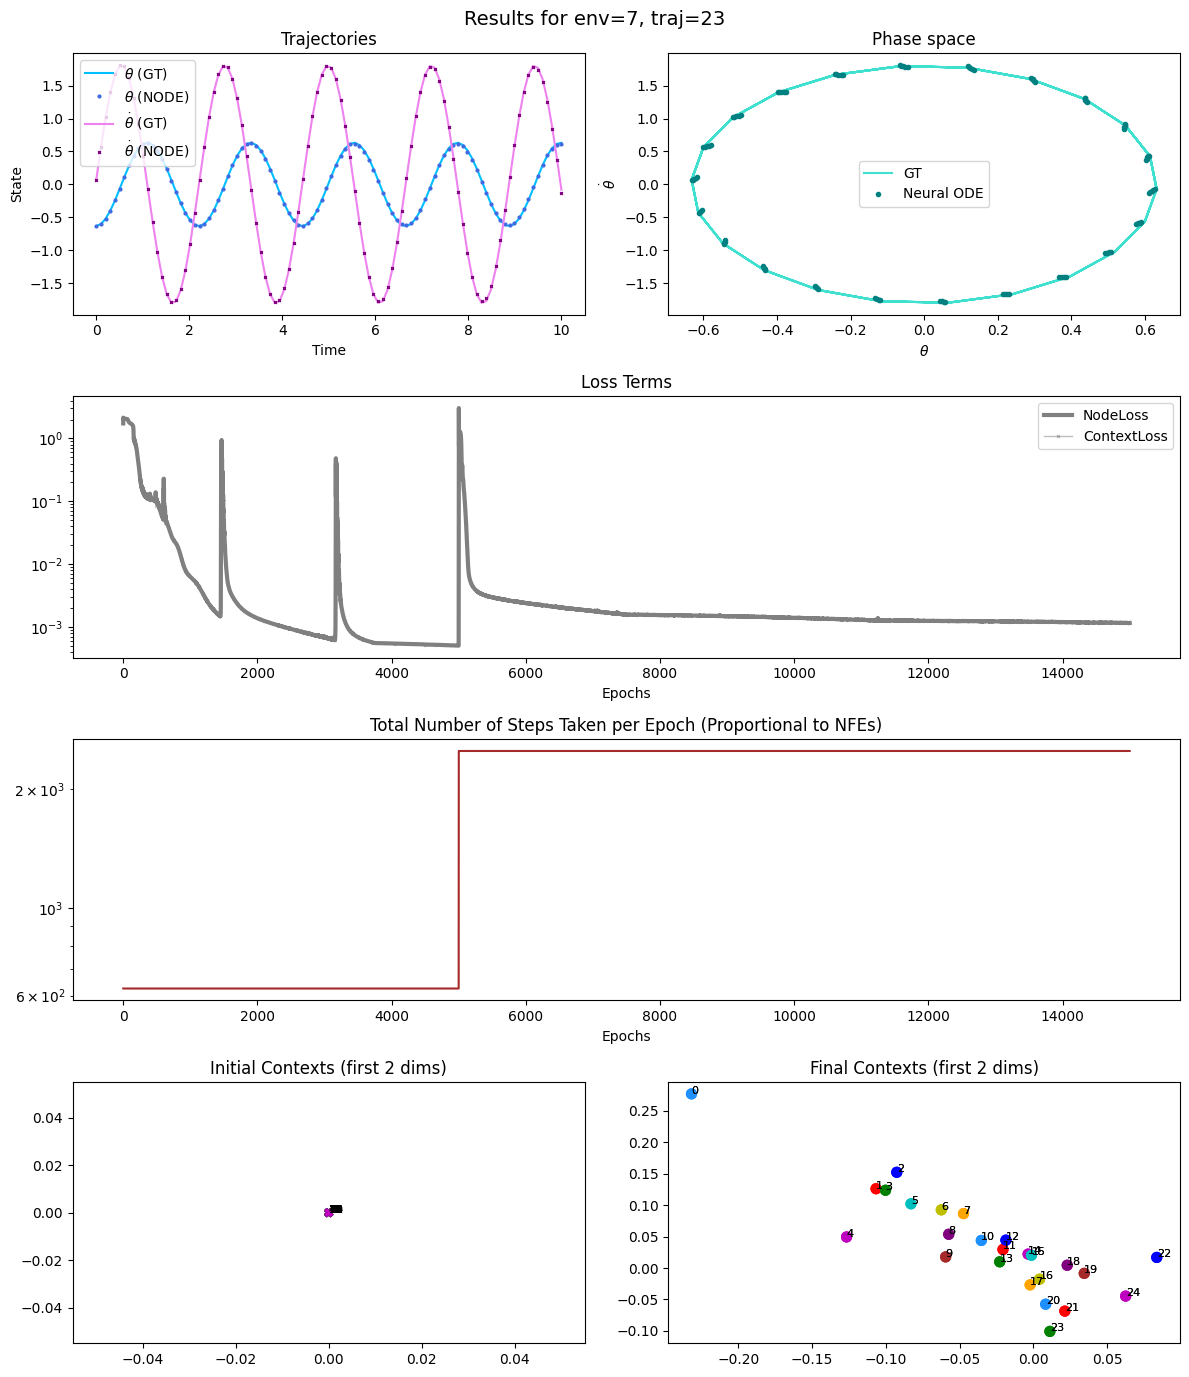

In [18]:
## Test and visualise the results on a test dataloader

test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)

visualtester = VisualTester(trainer)
# ans = visualtester.trainer.nb_steps_node
# print(ans.shape)

ind_crit = visualtester.test(test_dataloader, int_cutoff=1.0)

if finetune:
    savefigdir = finetunedir+"results_in_domain.png"
else:
    savefigdir = run_folder+"results_in_domain.png"
visualtester.visualize(test_dataloader, int_cutoff=1.0, save_path=savefigdir);

In [19]:
# len(trainer.losses_node

# ## Run and get the contexts
# for i in range(nb_envs):
#     ctx = trainer.learner.contexts.params[i]
#     # print(ctx)
#     param = ctx
#     for layer in trainer.learner.physics.layers_context:
#         param = layer(param)
#         # print("Context", ctx, "     Param", param)
#     param = jnp.abs(param)
#     print("Param:", param)

In [20]:
## Give the dataloader an id to help with restoration later on

adapt_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, data_id="170846", key=seed)

sched_ctx_new = optax.piecewise_constant_schedule(init_value=3e-4,
                        boundaries_and_scales={int(nb_epochs_adapt*0.25):0.1,
                                                int(nb_epochs_adapt*0.5):0.1,
                                                int(nb_epochs_adapt*0.75):0.1})
opt_adapt = optax.adabelief(sched_ctx_new)

if adapt == True:
    trainer.adapt(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
else:
    print("save_id:", adapt_dataloader.data_id)

    trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)

Dataset shape: (8, 1, 100, 2)


=== Beginning adaptation ... ===
    Number of examples in a batch: 1
    Number of train steps per epoch: 1
    Number of training epochs: 5000
    Total number of training steps: 5000

Compiling function "train_step" for context ...
Shapes of elements in a batch: (8, 1, 100, 2) (100,)
    Epoch:     0     LossContext: 3.30612564
    Epoch:     1     LossContext: 8.94005013
    Epoch:     2     LossContext: 8.93447113
    Epoch:     3     LossContext: 8.92941475
    Epoch:  1000     LossContext: 6.17775679
    Epoch:  2000     LossContext: 5.97956562
    Epoch:  3000     LossContext: 5.95435762
    Epoch:  4000     LossContext: 5.94983816
    Epoch:  4999     LossContext: 5.94797373

Total gradient descent adaptation time: 0 hours 4 mins 22 secs
Environment weights at the end of the adaptation: [0.01218706 0.01982087 0.02123887 0.01303069 0.02341652 0.35526052
 0.09839163 0.45665383]

Saving adaptation parameters into ./runs/30012024-165151/adapt/ folde

==  Begining out-of-distribution testing ... ==
    Number of training environments: 25
    Number of adaptation environments: 8
    Final length of the training trajectories: 100
    Length of the testing trajectories: 100
Test Score (OOD): 2.2469816

==  Begining out-of-distribution visualisation ... ==
    Environment id: 6
    Trajectory id: 0
    Final length of the training trajectories: 100
    Length of the testing trajectories: 100
Testing finished. Figure saved in: ./runs/30012024-165151/adapt/results_ood.png


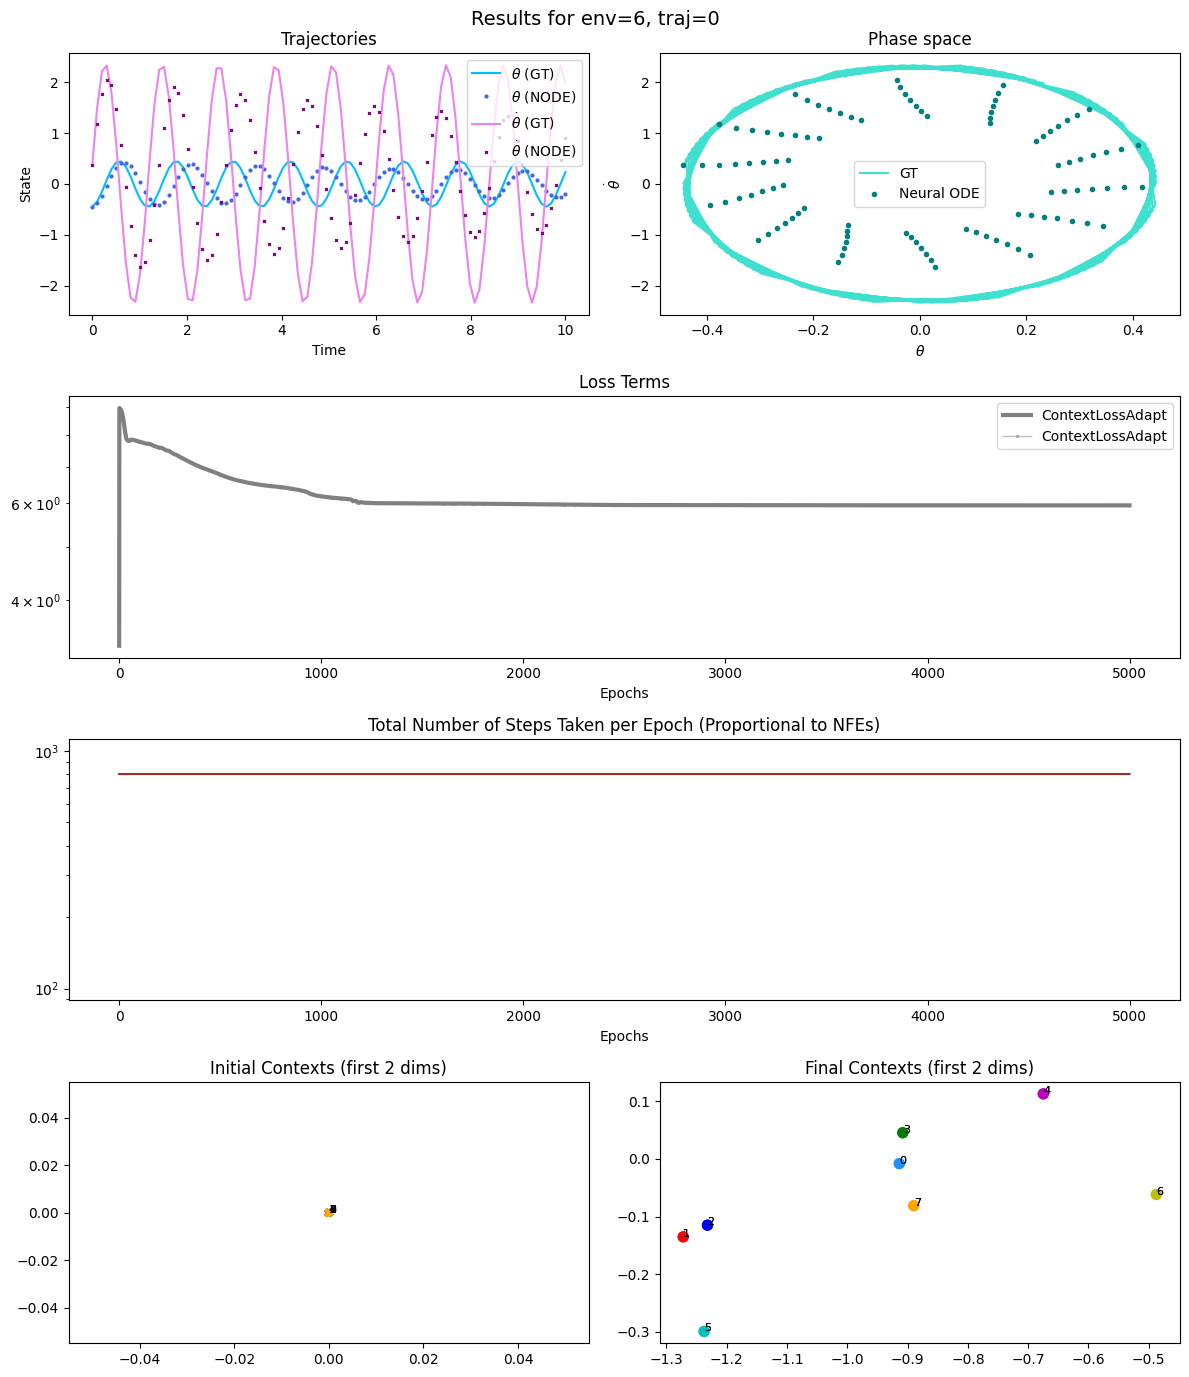

In [21]:
ood_crit = visualtester.test(adapt_dataloader, int_cutoff=1.0)      ## It's the same visualtester as before during training. It knows trainer

visualtester.visualize(adapt_dataloader, int_cutoff=1.0, save_path=adapt_folder+"results_ood.png");

In [22]:
# eqx.tree_deserialise_leaves(run_folder+"contexts.eqx", learner.contexts)

In [23]:
#### Generate data for analysis


# ## We want to store 3 values in a CSV file: "seed", "ind_crit", and "ood_crit", into the tmp/test_scores.csv file

# # First, check if the file exists. If not, create it and write the header
# if not os.path.exists('./tmp'):
#     os.mkdir('./tmp')

# if not os.path.exists('./tmp/test_scores.csv'):
#     os.system(f"touch ./tmp/test_scores.csv")

# with open('./tmp/test_scores.csv', 'r') as f:
#     lines = f.readlines()
#     if len(lines) == 0:
#         with open('./tmp/test_scores.csv', 'w') as f:
#             f.write("seed,ind_crit,ood_crit\n")






# for seed in range(4*10**3, 6*10**3, 200):

#     os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}"')
#     os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}"');

#     test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)
#     adapt_test_dataloader = DataLoader(adapt_folder+"adapt_test_data.npz", adaptation=True, key=seed)

#     ind_crit = visualtester.test(test_dataloader, int_cutoff=1.0)
#     ood_crit = visualtester.test(adapt_test_dataloader, int_cutoff=1.0)

#     # Then, append the values to the file
#     with open('./analysis/test_scores_2.csv', 'a') as f:
#         f.write(f"{seed},{ind_crit},{ood_crit}\n")

In [24]:
## Huge adaptation step to 51*51 environments and MAPE score computation



## Give the dataloader an id to help with restoration later on



# adapt_dataloader = DataLoader(adapt_folder+"adapt_huge_data.npz", adaptation=True, data_id="090142", key=seed)

# sched_ctx_new = optax.piecewise_constant_schedule(init_value=3e-4,
#                         boundaries_and_scales={int(nb_epochs_adapt*0.25):0.1,
#                                                 int(nb_epochs_adapt*0.5):0.1,
#                                                 int(nb_epochs_adapt*0.75):0.1})
# opt_adapt = optax.adabelief(sched_ctx_new)

# # nb_epochs_adapt = 2
# if adapt_huge == True:
#     trainer.adapt(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
# else:
#     print("save_id:", adapt_dataloader.data_id)

#     trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)

# ## Define mape criterion over a trajectory
# def mape(y, y_hat):
#     norm_traget = jnp.abs(y)
#     norm_diff = jnp.abs(y-y_hat)
#     ratios = jnp.mean(norm_diff/norm_traget, axis=-1)
#     return jnp.sum(ratios)

# ood_crit, odd_crit_all = visualtester.test(adapt_dataloader, criterion=mape)